In [1]:
import json
import numpy as np
from collections import defaultdict
from scipy.sparse import csr_matrix

In [2]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                        shape=loader['shape'])

In [3]:
with open('transmute_data.json') as f:
    data = json.load(f)
with open('sigma.json') as f:
    sigma = json.load(f)

In [4]:
nuc_idx = {n: i for i, n in enumerate(data['nucs'])}
N = len(nuc_idx)

In [5]:
decay_consts = {}
gammas = {}
for key, val in data['symbols'].items():
    if key.startswith('lambda'):
        _, n = key.split('_')
        decay_consts[n] = val
    elif key.startswith('gamma'):
        _, i, j, *_ = key.split('_')
        gammas[i, j] = val
    else:
        raise KeyError

In [6]:
sigma_ij = {(i, j): v for v, i, j in sigma.values() if v > 0.0 and j is not None}

In [7]:
phi = 4e14 * 1e-24  # flux, n / barn /s

In [8]:
dok = defaultdict(float) # indexed b y nuclide name
# let's first add the cross section channels
for i, val in data['channels'].items():
    for j in val.values():
        dok[j, i] += sigma_ij.get((j, i), 0.0) * phi
    for v, f, t in sigma.values():
        if t is None:
            continue
        if i == f:
            dok[i, i] -= v * phi
# now let's add the decay consts
for (i, j), g in gammas.items():
    dok[i, j] += g * decay_consts[i]
for i, v in decay_consts.items():
    dok[i, i] -= v

In [9]:
len(dok)

21225

In [10]:
rows = []
cols = []
vals = []
for (i, j), v in dok.items():
    if (v == 0.0) or (i not in nuc_idx) or (j not in nuc_idx):
        continue
    rows.append(nuc_idx[i])
    cols.append(nuc_idx[j])
    vals.append(v)

In [11]:
mat = csr_matrix((vals, (rows, cols)), shape=(N, N))

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

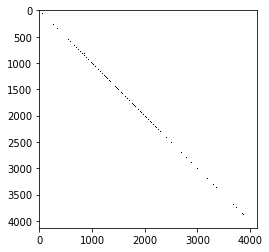

In [13]:
plt.imshow(mat.toarray() == 0.0, interpolation='none', cmap='gray')

In [14]:
save_sparse_csr('transmute.npz', mat)

In [15]:
lmat = load_sparse_csr('transmute.npz')

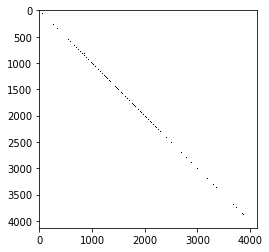

In [16]:
plt.imshow(lmat.toarray() == 0.0, interpolation='none', cmap='gray')

In [17]:
decay_consts['Br91']

1.1552453009332422

In [18]:
nuc_idx['']

912

In [19]:
[i for i in nuc_idx if nuc_idx[i] == 10]

['He4']

In [20]:
decay_consts['He4']

0.0

In [21]:
[i for i in sigma_ij if 'He4' in i]

[('He3', 'He4')]

In [22]:
sigma_ij[('He3', 'He4')]

59.99

In [23]:
[i for i in nuc_idx if nuc_idx[i] == 868]

['Se89']

In [24]:
365.25/12 * 24 * 60 * 60

2629800.0

In [25]:
2.6e6

2600000.0

In [26]:
[i for i in nuc_idx if nuc_idx[i] == 1387]

['Pd111']

In [27]:
nuc_idx['Rh117']

1352

In [28]:
nuc_idx['Ru117']

1300

In [29]:
nuc_idx['Tc117']

1263

In [30]:
nuc_idx['Nb117']

KeyError: 'Nb117'

In [ ]:
nuc_idx['Mo117']

In [ ]:
[i for i in nuc_idx if nuc_idx[i] == 1594]

In [ ]:
nuc_idx['Pd118']

In [ ]:
[i for i in sigma_ij if 'Sn117' in i]

In [ ]:
sigma_ij[('Sn117', None)]

In [ ]:
data['channels']['Sn117']

In [ ]:
[(i, sigma[i]) for i in sigma if 'In117M' in sigma[i]]

In [ ]:
nuc_idx['In117']

In [ ]:
nuc_idx['H1']

In [ ]:
np.log(2)/decay_consts['Pd117']

In [ ]:
[(i, sigma[i]) for i in sigma if "Ir180" in i]

In [ ]:
[i for i in sigma_ij if 'Ir180' in i]

In [ ]:
[(i, gammas[i]) for i in gammas if 'In117M' in i]

In [ ]:
np.log(2)/decay_consts['Cd117']/60/60

In [34]:
data['nucs'][59]

'Co59'

In [ ]:
for f in data['channels']:
    for type in data['channels'][f]:
        t = data['channels'][f][type]
        assert "sigma_" + type + "_" + t in sigma, (type, f)

In [ ]:
sigma['sigma_alpha_Ir180']

In [ ]:
data['channels']["Ir180"]

In [ ]:
np.exp(-0.77*phi*2.6e6)

In [ ]:
phi

In [ ]:
for i in sorted([(sum(v for (i, j), v in gammas.items() if i == f), f) for f in nuc_idx]):
    print(i)

NameError: name 'nucs' is not defined